# Exploring the HEK - with Python!

The goal of this notebook is to indroduce you to the Heliophysics Events Knowledgebase (HEK) data. It uses the sunpy interface to get the data from the HEK. I then demonstrate how to use the data in python by using what is called a pandas data frame.  This makes it easy to split data, plot feature, and merge datasets together. 

In [ ]:
%matplotlib inline
#The above line should be included in all notebooks. It ensures that all plots are printed within this notebook. 
#If you don't include it, plots will appear in a popup window and it is really annoying. 

In [65]:
#I like to import all of the python packages in the first cell of a notebook so you can see what you will be using
#You can always add to this list later as you go along
#This is also a good way to know which packages you should have installed on your machine in order to run the code
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sunpy.net import hek
import matplotlib.pyplot as plt

In [15]:
#Create a client that will search the HEK. 
#To then make a query, you just need to supply a start and end time and the event type (there are other things you can do to narrow it down if you want)
#This example searches for all flares on Jan 1 as recorded by the flare detective trigger module
client = hek.HEKClient()
start_time = pd.to_datetime('2016/01/01 00:00')
end_time = pd.to_datetime('2016/01/02 00:00')
hek_events = client.query(hek.attrs.Time(start_time.isoformat(),
                                                 end_time.isoformat()),
                                  hek.attrs.EventType('FL'),
                                  hek.attrs.FRM.Name == 'Flare Detective - Trigger Module')
       


In [22]:
#Looks at the results. If you run this cell, you can see that there were 33 flares recorded by the HEK at this time.
print 'There were %d flares in this time frame' % len(hek_events)
#Uncomment this to print all of the keys. There were a ton and it clutters up the notebook, so I didn't do it here. 
#hek_events[0].keys() #This prints all of the keys the flare data contains

There were 33 flares in this time frame


In [20]:
#This is an easy way to print out the peak time for each of the flares found
[elem["event_peaktime"] for elem in hek_events]

[u'2016-01-01T00:59:33',
 u'2016-01-01T02:09:21',
 u'2016-01-01T03:01:33',
 u'2016-01-01T02:54:23',
 u'2016-01-01T02:53:48',
 u'2016-01-01T04:41:21',
 u'2016-01-01T05:50:21',
 u'2016-01-01T05:44:59',
 u'2016-01-01T06:38:57',
 u'2016-01-01T06:37:47',
 u'2016-01-01T06:37:30',
 u'2016-01-01T06:37:48',
 u'2016-01-01T06:37:43',
 u'2016-01-01T09:18:57',
 u'2016-01-01T09:48:09',
 u'2016-01-01T09:58:42',
 u'2016-01-01T09:43:47',
 u'2016-01-01T09:43:48',
 u'2016-01-01T12:03:57',
 u'2016-01-01T14:12:09',
 u'2016-01-01T15:07:21',
 u'2016-01-01T17:09:09',
 u'2016-01-01T20:20:45',
 u'2016-01-01T20:20:23',
 u'2016-01-01T20:20:24',
 u'2016-01-01T20:20:18',
 u'2016-01-01T22:30:21',
 u'2016-01-01T22:28:35',
 u'2016-01-01T22:29:30',
 u'2016-01-01T22:28:36',
 u'2016-01-01T22:31:13',
 u'2016-01-01T22:33:59',
 u'2016-01-02T00:05:57']

In [21]:
#Tells you what wavelength the flare was detected in. 
#Unfortunately the HEK lists a separate flare event for each AIA channel, even though they are the same event. 
[elem["obs_channelid"] for elem in hek_events]

[u'131',
 u'131',
 u'131',
 u'171',
 u'211',
 u'131',
 u'131',
 u'171',
 u'131',
 u'171',
 u'193',
 u'211',
 u'304',
 u'131',
 u'131',
 u'193',
 u'171',
 u'211',
 u'131',
 u'131',
 u'131',
 u'131',
 u'131',
 u'171',
 u'211',
 u'193',
 u'131',
 u'171',
 u'193',
 u'211',
 u'94',
 u'171',
 u'131']

In [23]:
#OK, now lets see what we have for the emerging flux. 
#This is the same search, but I changed hek.attrs.EventType
ef_events = client.query(hek.attrs.Time(start_time.isoformat(),
                                                 end_time.isoformat()),
                                  hek.attrs.EventType('EF'))

In [89]:
print 'There were %d emerging flux events in this time frame' % len(ef_events)

#ef_events[0].keys() #This prints all of the keys the flare data contains. Again, ther are lots so it clutters the notebook

There were 17 emerging flux events in this time frame


In [41]:
#Convert the data to a pandas dataframe. This is just an easy way of displaying and storing columnated data
ef = pd.DataFrame(ef_events)

In [42]:
#Some of the keywords are not populated. Get rid of all columns that contain no information
ef = ef.dropna(axis=1,how='all') #If you use how='any' it will get rid of a column if any of the rows is empty. 
ef.head() #calling a pandas dataframe.head() will print out the first 5 rows. df.tail() prints the last 5 rows. 

,SOL_standard,active,ar_compactnesscls,ar_mcintoshcls,ar_mtwilsoncls,ar_noaaclass,ar_penumbracls,ar_zurichcls,area_atdiskcenter,area_atdiskcenteruncert,...,obs_lastprocessingdate,obs_meanwavel,obs_observatory,obs_title,obs_wavelunit,rasterscan,rasterscantype,refs,refs_orig,revision
0,SOL2015-12-31T22:32:15L304C080,true,,,,,,,124221000,153152992,...,,0.000534,SDO/HMI,,cm,,,"[{u'ref_type': u'thumbnail', u'ref_url': u'htt...",,2
1,SOL2015-12-31T23:56:15L287C111,true,,,,,,,91265696,167597008,...,,0.000534,SDO/HMI,,cm,,,"[{u'ref_type': u'thumbnail', u'ref_url': u'htt...",,2
2,SOL2016-01-01T00:20:15L303C081,true,,,,,,,105495000,191910000,...,,0.000534,SDO/HMI,,cm,,,"[{u'ref_type': u'thumbnail', u'ref_url': u'htt...",,2
3,SOL2016-01-01T02:34:30L255C086,true,,,,,,,883116992,1513890048,...,,0.000534,SDO/HMI,,cm,,,"[{u'ref_type': u'thumbnail', u'ref_url': u'htt...",,2
4,SOL2016-01-01T02:58:30L305C105,true,,,,,,,91596200,128325000,...,,0.000534,SDO/HMI,,cm,,,"[{u'ref_type': u'thumbnail', u'ref_url': u'htt...",,2


In [66]:
#Make a function so that all of the column names will be displayed. If not, the default cuts the middle out. 
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [67]:
#print all of the data for the first element in the emerging flux dataset
#note: for pandas dataframes, you need to use ef.iloc[0] to reference a row, not just ef[0]
#This uses the function defined in the cell above
print_full(ef.iloc[0])

SOL_standard                                       SOL2015-12-31T22:32:15L304C080
active                                                                       true
ar_compactnesscls                                                                
ar_mcintoshcls                                                                   
ar_mtwilsoncls                                                                   
ar_noaaclass                                                                     
ar_penumbracls                                                                   
ar_zurichcls                                                                     
area_atdiskcenter                                                       124221000
area_atdiskcenteruncert                                                 153152992
area_raw                                                                107627000
area_uncert                                                             132694000
area_unit       

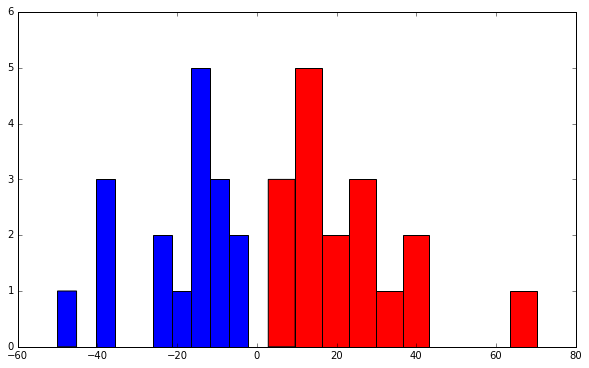

In [88]:
#This plots a histogram with both the sum of the negative (blue) and positive (red) flux
plt.figure(figsize=(10,6))
plt.ylim([0,6])
plt.hist(ef['ef_sumnegsignedflux'])
plt.hist(ef['ef_sumpossignedflux'], color='r')
plt.show()


#ef['maxmagfieldstrength'].plot(kind='hist')